In [47]:
import torch
import numpy as np
import umap.umap_ as umap
import supervision as sv
import cv2
from tqdm import tqdm
from typing import List
from inference import get_model
from transformers import AutoProcessor, SiglipVisionModel
from sklearn.cluster import KMeans
from typing import Generator, Iterable, List, TypeVar

In [48]:
ROBOFLOW_API_KEY ="19956OGitmg91nRKHH4L"

PLAYER_DETECTION_MODEL_ID="basketball-players-fy4c2/25"
PLAYER_MODEL_DETECTION=get_model(model_id=PLAYER_DETECTION_MODEL_ID, api_key=ROBOFLOW_API_KEY)

FIELD_DETECTION_MODEL_ID="basketball_court_segmentation-tlfja/5"
FIELD_MODEL_DETECTION=get_model(model_id=FIELD_DETECTION_MODEL_ID, api_key=ROBOFLOW_API_KEY)

HANDLER_DETECTION_MODEL_ID="basketball_and_hoops/3"
HANDLER_MODEL_DETECTION=get_model(model_id=HANDLER_DETECTION_MODEL_ID, api_key=ROBOFLOW_API_KEY)

In [49]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using cuda device


In [50]:
SOURCE_VIDEO_PATH="./testFinal.mp4"
TAGET_VIDEO_PATH="./testFinal_result_1.mp4"

STRIDE=30

HANDEL=0
BALL_ID = 1
HOOP_ID = 2
PLAYER_ID = 4
REFEREE_ID = 5

In [58]:
box_annotation= sv.BoxAnnotator(
    color=sv.ColorPalette.from_hex(["#FF0000", "#00FF00", "#0000FF", "#FFFF00"]),
    thickness=2
)

labels_annotater= sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(["#FF0000", "#00FF00", "#0000FF", "#FFFF00"]),
    text_color=sv.Color.from_hex("#000000")
)

video_info= sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink=sv.VideoSink(TAGET_VIDEO_PATH, video_info=video_info)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

with video_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        result= PLAYER_MODEL_DETECTION.infer(frame, confidence=0.3, device=device)[0]
        detections= sv.Detections.from_inference(result)

        labels=[
            f"{class_name} {confidence:.2f}"
            for class_name, confidence
            in zip(detections["class_name"], detections.confidence)
        ]

        annotated_frame= frame.copy()
        annotated_frame= box_annotation.annotate(annotated_frame, detections)
        annotated_frame= labels_annotater.annotate(annotated_frame, detections, labels=labels)
        
        video_sink.write_frame(annotated_frame)


  1%|▏         | 4/313 [00:00<00:37,  8.26it/s]


KeyboardInterrupt: 

In [ ]:
SIGLIP_MODEL_PATH = 'google/siglip-base-patch16-224'

EMBEDDINGS_MODEL = SiglipVisionModel.from_pretrained(SIGLIP_MODEL_PATH).to(device)
EMBEDDINGS_PROCESSOR = AutoProcessor.from_pretrained(SIGLIP_MODEL_PATH)

In [52]:
V = TypeVar("V")

SIGLIP_MODEL_PATH = 'google/siglip-base-patch16-224'


def create_batches(
    sequence: Iterable[V], batch_size: int
) -> Generator[List[V], None, None]:
    """
    Generate batches from a sequence with a specified batch size.

    Args:
        sequence (Iterable[V]): The input sequence to be batched.
        batch_size (int): The size of each batch.

    Yields:
        Generator[List[V], None, None]: A generator yielding batches of the input
            sequence.
    """
    batch_size = max(batch_size, 1)
    current_batch = []
    for element in sequence:
        if len(current_batch) == batch_size:
            yield current_batch
            current_batch = []
        current_batch.append(element)
    if current_batch:
        yield current_batch


class TeamClassifier:
    """
    A classifier that uses a pre-trained SiglipVisionModel for feature extraction,
    UMAP for dimensionality reduction, and KMeans for clustering.
    """
    def __init__(self, device: str = 'cpu', batch_size: int = 32):
        """
       Initialize the TeamClassifier with device and batch size.

       Args:
           device (str): The device to run the model on ('cpu' or 'cuda').
           batch_size (int): The batch size for processing images.
       """
        self.device = device
        self.batch_size = batch_size
        self.features_model = SiglipVisionModel.from_pretrained(
            SIGLIP_MODEL_PATH).to(device)
        self.processor = AutoProcessor.from_pretrained(SIGLIP_MODEL_PATH)
        self.reducer = umap.UMAP(n_components=3)
        self.cluster_model = KMeans(n_clusters=2)

    def extract_features(self, crops: List[np.ndarray]) -> np.ndarray:
        """
        Extract features from a list of image crops using the pre-trained
            SiglipVisionModel.

        Args:
            crops (List[np.ndarray]): List of image crops.

        Returns:
            np.ndarray: Extracted features as a numpy array.
        """
        crops = [sv.cv2_to_pillow(crop) for crop in crops]
        batches = create_batches(crops, self.batch_size)
        data = []
        with torch.no_grad():
            for batch in tqdm(batches, desc='Embedding extraction'):
                inputs = self.processor(
                    images=batch, return_tensors="pt").to(self.device)
                outputs = self.features_model(**inputs)
                embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
                data.append(embeddings)

        return np.concatenate(data)

    def fit(self, crops: List[np.ndarray]) -> None:
        """
        Fit the classifier model on a list of image crops.

        Args:
            crops (List[np.ndarray]): List of image crops.
        """
        data = self.extract_features(crops)
        projections = self.reducer.fit_transform(data)
        self.cluster_model.fit(projections)

    def predict(self, crops: List[np.ndarray]) -> np.ndarray:
        """
        Predict the cluster labels for a list of image crops.

        Args:
            crops (List[np.ndarray]): List of image crops.

        Returns:
            np.ndarray: Predicted cluster labels.
        """
        if len(crops) == 0:
            return np.array([])

        data = self.extract_features(crops)
        projections = self.reducer.transform(data)
        return self.cluster_model.predict(projections)


collecting crops: 197it [00:16, 11.79it/s]
Embedding extraction: 33it [00:10,  3.18it/s]
Embedding extraction: 33it [00:10,  3.25it/s]


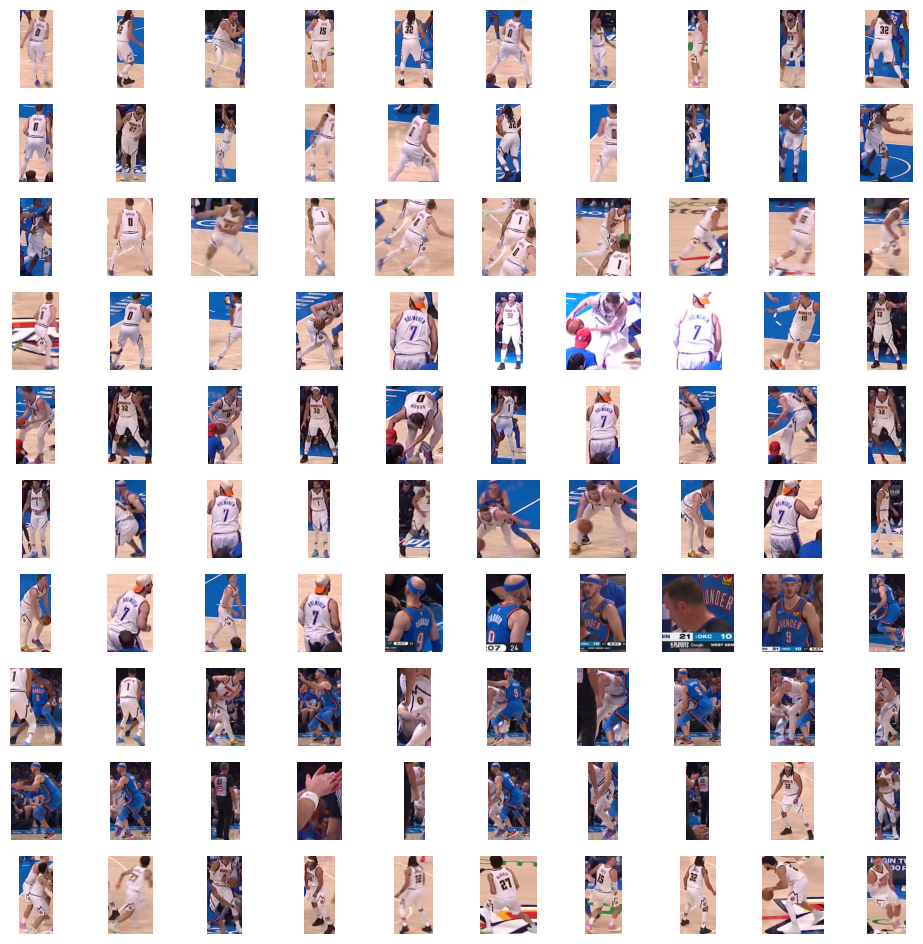

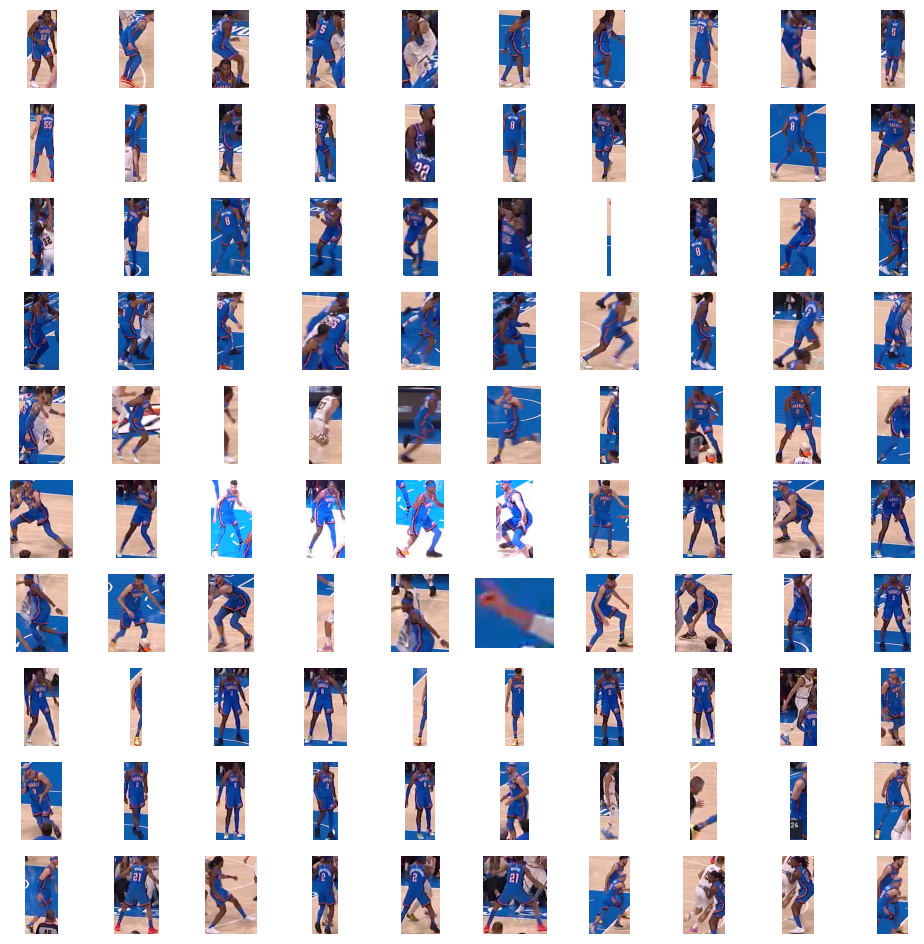

In [53]:
frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    result = PLAYER_MODEL_DETECTION.infer(frame, device=device, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)
    detections = detections.with_nms(threshold=0.5, class_agnostic=True)
    detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

team_classifier = TeamClassifier(device="cuda")


team_classifier.fit(crops)

clusters = team_classifier.predict(crops)

team_0 = [
    crop
    for crop, cluster
    in zip(crops, clusters)
    if cluster == 0
]


team_1 = [
    crop
    for crop, cluster
    in zip(crops, clusters)
    if cluster == 1
]

# Visualize samples from each team
sv.plot_images_grid(team_0[:100], grid_size=(10, 10))
sv.plot_images_grid(team_1[:100], grid_size=(10, 10))

Embedding extraction: 1it [00:00,  9.67it/s]
Embedding extraction: 1it [00:00, 12.05it/s]


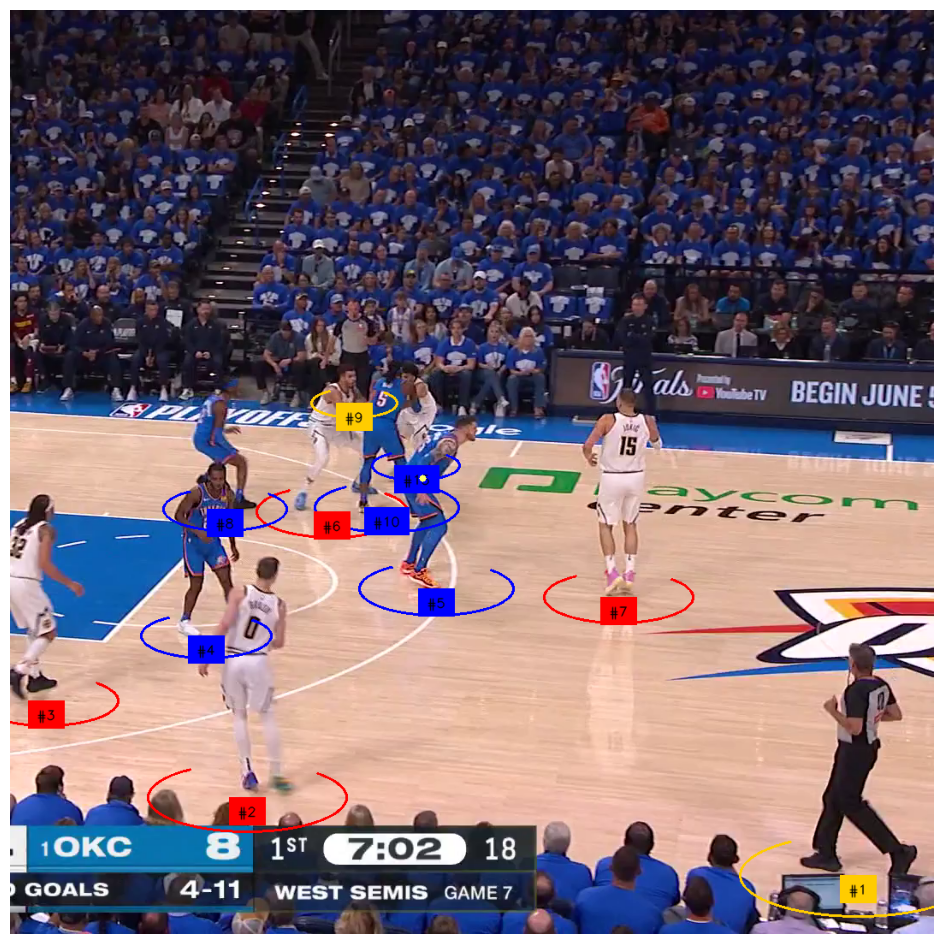

In [54]:

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#FF0000', '#0000FF', '#FFCC00']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#FF0000', '#0000FF', '#FFCC00']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFFF66'),
    base=25,
    height=21,
    outline_thickness=1
)
corner_annotator = sv.BoxCornerAnnotator(
     color=sv.Color.from_hex('#FFFF66'),
)
dot_annotator = sv.DotAnnotator(
     color=sv.Color.from_hex('#FFFF66')
)

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)   

result = PLAYER_MODEL_DETECTION.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

hoop_detections = detections[detections.class_id == HOOP_ID]
hoop_detections.xyxy = sv.pad_boxes(xyxy=hoop_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections = tracker.update_with_detections(detections=all_detections)

players_detections = all_detections[all_detections.class_id == PLAYER_ID]
referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(players_crops)

players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(players_crops)

all_detections = sv.Detections.merge([
    players_detections, referees_detections])

result = HANDLER_MODEL_DETECTION.infer(frame, confidence=0.3)[0]
detections_handler = sv.Detections.from_inference(result)

handler_detections = detections_handler[detections_handler.class_id == HANDEL]

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

all_detections.class_id = all_detections.class_id.astype(int)

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)
annotated_frame = corner_annotator.annotate(
    scene=annotated_frame,
    detections=hoop_detections)
annotated_frame = corner_annotator.annotate(
    scene=annotated_frame,
    detections=hoop_detections)
annotated_frame = dot_annotator.annotate(
    scene=annotated_frame,
    detections=handler_detections)

sv.plot_image(annotated_frame)

In [ ]:
!python -m a2.annotate --source_image_directory "C:\Users\nicol\Proyectos\IA\YoLo\NBa\annotet\mis_frames" --target_annotation_directory "C:\Users\nicol\Proyectos\IA\YoLo\NBa\annotet\labels2" --roboflow_project_id basketball_court_segmentation-tlfja --roboflow_project_version 1

c:\Users\nicol\Proyectos\VIrtualEnv\roboflow\Scripts\python.exe: Error while finding module specification for 'C:\\Users\\nicol\\Proyectos\\IA\\YoLo\\auto-annotate\\a2\\annotate.py' (ModuleNotFoundError: No module named 'C:\\Users\\nicol\\Proyectos\\IA\\YoLo\\auto-annotate\\a2\\annotate'). Try using 'C:\Users\nicol\Proyectos\IA\YoLo\auto-annotate\a2\annotate' instead of 'C:\Users\nicol\Proyectos\IA\YoLo\auto-annotate\a2\annotate.py' as the module name.


[5 4 4 4 4 4 4 4 5 4 9 3 8 6 4 8 7]


Embedding extraction: 1it [00:00, 12.18it/s]
Embedding extraction: 1it [00:00, 13.53it/s]


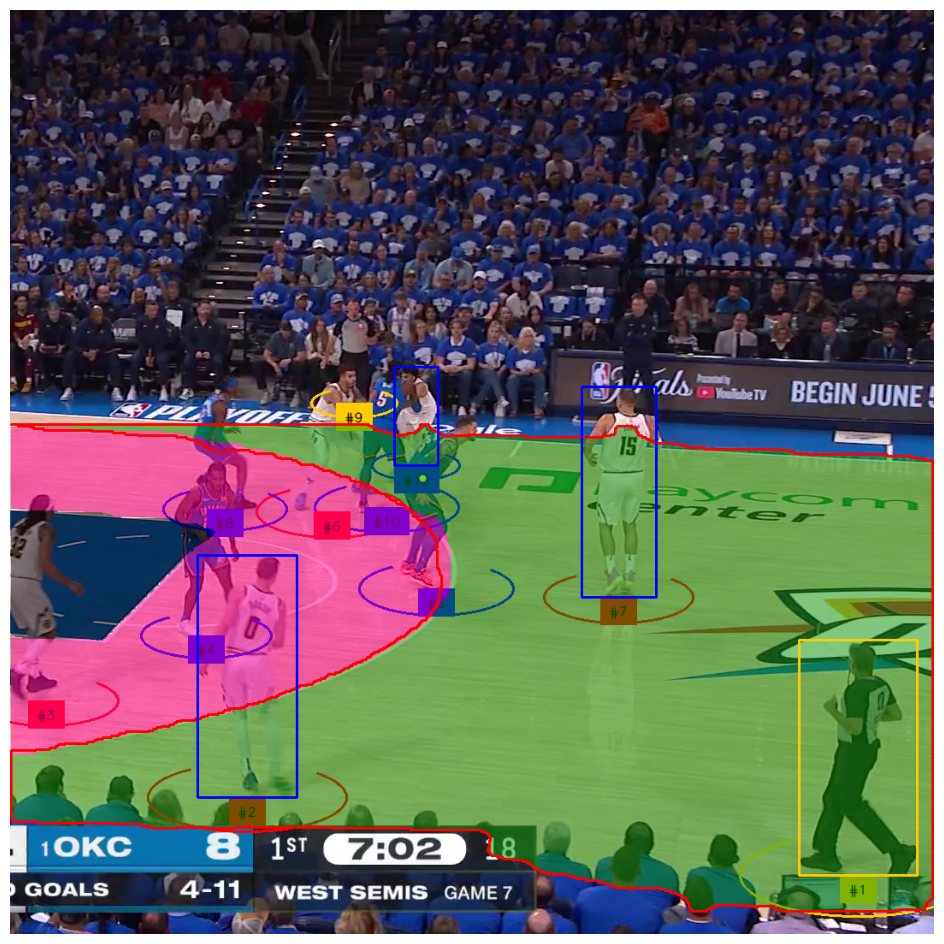

In [55]:
box_annotator  = sv.BoxAnnotator(
    color=sv.ColorPalette.from_hex(['#FF0000', '#0000FF', '#FFCC00']),
    thickness=2
)
mask_annotator = sv.MaskAnnotator(
    color=sv.ColorPalette.from_hex(['#009900', '#000000', '#FF0099']),
    opacity=0.5
)

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#FF0000', '#0000FF', '#FFCC00']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#FF0000', '#0000FF', '#FFCC00']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFFF66'),
    base=25,
    height=21,
    outline_thickness=1
)
corner_annotator = sv.BoxCornerAnnotator(
     color=sv.Color.from_hex('#FFFF66'),
)
corner_annotatorTrue = sv.BoxCornerAnnotator(
     color=sv.Color.from_hex('#00913F'),
)
dot_annotator = sv.DotAnnotator(
     color=sv.Color.from_hex('#FFFF66')
)


tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_MODEL_DETECTION.infer(frame, device=device, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

print(detections.class_id)


ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

hoop_detections = detections[detections.class_id == HOOP_ID]
hoop_detections.xyxy = sv.pad_boxes(xyxy=hoop_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections = tracker.update_with_detections(detections=all_detections)

players_detections = all_detections[all_detections.class_id == PLAYER_ID]
referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(players_crops)

players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(players_crops)

all_detections = sv.Detections.merge([
    players_detections, referees_detections])

result = HANDLER_MODEL_DETECTION.infer(frame, confidence=0.3)[0]
detections_handler = sv.Detections.from_inference(result)

handler_detections = detections_handler[detections_handler.class_id == HANDEL]

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

all_detections.class_id = all_detections.class_id.astype(int)

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)
annotated_frame = corner_annotator.annotate(
    scene=annotated_frame,
    detections=hoop_detections)
annotated_frame = dot_annotator.annotate(
    scene=annotated_frame,
    detections=handler_detections)


result = FIELD_MODEL_DETECTION.infer(frame, device=device, confidence=0.3)[0]
zones = sv.Detections.from_inference(result)

annotated_frame = mask_annotator.annotate(
    scene=annotated_frame,
    detections=zones)

try:
    if zones.mask is not None and len(zones.mask) > 0:
        # Elige una clase específica de zona que quieras usar (ej: class_id == 1)
        target_class_id = 0  # Ajusta este valor según tu necesidad
        
        # Filtra las zonas por class_id
        target_zones = zones[zones.class_id == target_class_id]
        
        if len(target_zones) > 0:
            # Usa la primera zona que coincida con el class_id
            mask = target_zones.mask[0]
            polygons = sv.mask_to_polygons(mask)
            
            if len(polygons) > 0:
                polygon_zone = sv.PolygonZone(polygon=polygons[0])
                detections_in_zone = detections[polygon_zone.trigger(detections)]
                
                annotated_frame = sv.draw_polygon(
                    scene=annotated_frame,
                    polygon=polygons[0],
                    color=sv.Color.from_hex('#FF0000'),
                    thickness=2
                )
                
                annotated_frame = box_annotator.annotate(
                    scene=annotated_frame,
                    detections=detections_in_zone
                )
except Exception as e:
    print(e)
    pass
    

sv.plot_image(annotated_frame)

In [56]:
def is_inside(objeto, zona, partial_overlap=True):
    """
        Verifica si el objeto está dentro o solapando la zona.
            
    Args:
        objeto (np.ndarray): Bounding box del objeto [x1, y1, x2, y2]
        zona (np.ndarray): Bounding box de la zona [x1, y1, x2, y2]
        partial_overlap (bool): Si True, devuelve True si hay superposición parcial.
                            Si False, solo devuelve True si el objeto está completamente dentro.
            
    Returns:
        bool: True si el objeto está dentro/solapando, False en caso contrario.
    """
    if len(objeto.shape) > 1:
        objeto = objeto[0]  # Toma la primera fila si es multidimensional
    if len(zona.shape) > 1:
        zona = zona[0]
            
    if partial_overlap:
        # Verifica si hay superposición (incluso parcial)
        
        return not (objeto[2] <= zona[0] or  
                objeto[0] >= zona[2] or  
                objeto[3] <= zona[1] or  
                objeto[1] >= zona[3]) 
    else:
        # Verifica si el objeto está completamente dentro (versión original)
        return (objeto[0] >= zona[0] and
                objeto[1]+20 >= zona[1] and
                objeto[2] <= zona[2] and
                objeto[3] <= zona[3]+25)

Embedding extraction: 1it [00:00,  4.44it/s]
Embedding extraction: 1it [00:00,  4.36it/s]


False


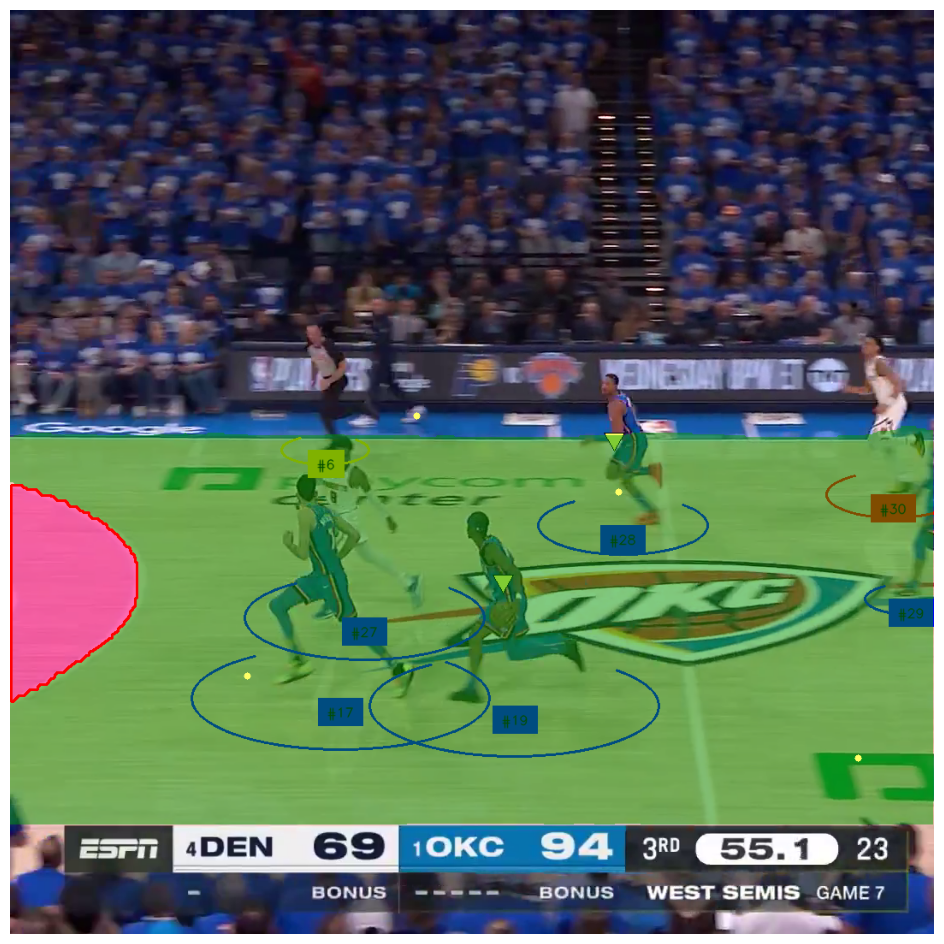

In [59]:

TARGET_FRAME_NUMBER = 5000 # El número del frame que quieres extraer

real_handler=[]
last_handler=True

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
for i, frame in enumerate(frame_generator):
    if i == TARGET_FRAME_NUMBER:
                
        result = PLAYER_MODEL_DETECTION.infer(frame, device=device, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)

        ball_detections = detections[detections.class_id == BALL_ID]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

        hoop_detections = detections[detections.class_id == HOOP_ID]
        hoop_detections.xyxy = sv.pad_boxes(xyxy=hoop_detections.xyxy, px=10)

        all_detections = detections[detections.class_id != BALL_ID]
        all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
        all_detections = tracker.update_with_detections(detections=all_detections)

        players_detections = all_detections[all_detections.class_id == PLAYER_ID]
        referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

        players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
        players_detections.class_id = team_classifier.predict(players_crops)

        players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
        players_detections.class_id = team_classifier.predict(players_crops)
        

        try:
            ball_xyxy = ball_detections.xyxy[0]  
        except:
            pass
                
        try:
            hoop_xyxy = hoop_detections.xyxy[0]
        except:
            pass
        
        esta_dentro=False
        
        try:
            esta_dentro = is_inside(ball_xyxy, hoop_xyxy, partial_overlap=False)
        except:
            pass

        all_detections = sv.Detections.merge([
            players_detections, referees_detections])
        
        result = HANDLER_MODEL_DETECTION.infer(frame, confidence=0.3)[0]
        detections_handler = sv.Detections.from_inference(result)

        handler_detections = detections_handler[detections_handler.class_id == HANDEL]
        
        if len(handler_detections) > 0:
            # Encontrar el índice de la detección con mayor confianza
            max_confidence_idx = int(handler_detections.confidence.argmax())
            
            # Seleccionar solo esa detección
            handler_detections = handler_detections[max_confidence_idx]
            
                
        try:
            handler_xyxy=handler_detections.xyxy[0]
        except:
            pass

        try:
            esta_tirando= is_inside(handler_xyxy, ball_xyxy)
        except:
            pass
        real_handler=[]
    
        
        if esta_tirando:
            real_handler= handler_detections


        labels = [
            f"#{tracker_id}"
            for tracker_id
            in all_detections.tracker_id
        ]

        all_detections.class_id = all_detections.class_id.astype(int)

        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(
            scene=annotated_frame,
            detections=all_detections)
        annotated_frame = label_annotator.annotate(
            scene=annotated_frame,
            detections=all_detections,
            labels=labels)
        annotated_frame = triangle_annotator.annotate(
            scene=annotated_frame,
            detections=ball_detections)
        annotated_frame = box_annotator.annotate(
            scene=annotated_frame,
            detections=real_handler)
     
        
        if esta_dentro:
            annotated_frame = corner_annotatorTrue.annotate(
                scene=annotated_frame,
                detections=hoop_detections)
        else:
            annotated_frame = corner_annotator.annotate(
                scene=annotated_frame,
                detections=hoop_detections)
    

        result = FIELD_MODEL_DETECTION.infer(frame, device=device, confidence=0.3)[0]
        zones = sv.Detections.from_inference(result)

        annotated_frame = mask_annotator.annotate(
            scene=annotated_frame,
            detections=zones)

        try:
            if zones.mask is not None and len(zones.mask) > 0:
                # Elige una clase específica de zona que quieras usar (ej: class_id == 1)
                target_class_id_1 = 1  # Ajusta este valor según tu necesidad
                target_class_id_2 = 2  # Ajusta este valor según tu necesidad
                
                # Filtra las zonas por class_id
                target_zones = zones[(zones.class_id == target_class_id_1) | (zones.class_id == target_class_id_2)]
                
                last_handler = True
                
                for mask in target_zones.mask:
                    polygons = sv.mask_to_polygons(mask)
                    
                    if len(polygons) > 0:
                        polygon_zone = sv.PolygonZone(polygon=polygons[0])
                        # Solo considerar detecciones de jugadores
                        players_only_detections = detections[detections.class_id == PLAYER_ID]
                        
                        try:
                            # Aplicar el trigger sobre las detecciones de jugadores
                            detections_in_zone = real_handler[polygon_zone.trigger(real_handler)] 
                        except:
                            pass

                        
                        if len(detections_in_zone.xyxy) > 0:
                            last_handler = False
                            
                        
                        # Dibujar polígono en el frame
                        annotated_frame = sv.draw_polygon(
                            scene=annotated_frame,
                            polygon=polygons[0],
                            color=sv.Color.from_hex('#FF0000'),
                            thickness=2
                        )
                        
                        # Anotar detecciones dentro de la zona
                        annotated_frame = dot_annotator.annotate(
                            scene=annotated_frame,
                            detections=detections_in_zone
                        )
                        
                print(last_handler)
        except Exception as e:
            print(e)
            pass

        sv.plot_image(annotated_frame)
        break  # Salimos del bucle una vez encontrado el frame
    

In [61]:
# TAGET_VIDEO_PATH="./stepback_result_1.mp4"
# SOURCE_VIDEO_PATH="./stepback.mp4"

video_info= sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink=sv.VideoSink(TAGET_VIDEO_PATH, video_info=video_info)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

TEXT_DURATION_FRAMES = 30  # Número de frames que el texto permanecerá visible
active_text = None  # Guarda el texto actual ("3Puntos" o "2Puntos")
remaining_frames = 0  # Frames restantes para ocultar el texto

aux= False
last_handler=True
with video_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames): 
        result = PLAYER_MODEL_DETECTION.infer(frame, device=device, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)


        ball_detections = detections[detections.class_id == BALL_ID]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

        hoop_detections = detections[detections.class_id == HOOP_ID]
        hoop_detections.xyxy = sv.pad_boxes(xyxy=hoop_detections.xyxy, px=10)

        all_detections = detections[detections.class_id != BALL_ID]
        all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
        all_detections = tracker.update_with_detections(detections=all_detections)

        players_detections = all_detections[all_detections.class_id == PLAYER_ID]
        referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

        players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
        players_detections.class_id = team_classifier.predict(players_crops)

        players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
        players_detections.class_id = team_classifier.predict(players_crops)
        
        try:
            ball_xyxy = ball_detections.xyxy[0]  
        except:
            pass
                
        try:
            hoop_xyxy = hoop_detections.xyxy[0]
        except:
            pass
        
        esta_dentro=False
        
        try:
            esta_dentro = is_inside(ball_xyxy, hoop_xyxy, partial_overlap=False)
        except:
            pass
        
        
        if esta_dentro:
            aux=True
        
        
        all_detections = sv.Detections.merge([
            players_detections, referees_detections])
        
        result = HANDLER_MODEL_DETECTION.infer(frame, confidence=0.3)[0]
        detections_handler = sv.Detections.from_inference(result)

        handler_detections = detections_handler[detections_handler.class_id == HANDEL]
        
        if len(handler_detections) > 0:
            # Encontrar el índice de la detección con mayor confianza
            max_confidence_idx = int(handler_detections.confidence.argmax())
            
            # Seleccionar solo esa detección
            handler_detections = handler_detections[max_confidence_idx]
            
        try:
            handler_xyxy=handler_detections.xyxy[0]
        except:
            pass

        try:
            esta_tirando= is_inside(handler_xyxy, ball_xyxy)
        except:
            pass
        real_handler=[]
    
        
        if esta_tirando:
            real_handler= handler_detections
            
            
        labels = [
            f"#{tracker_id}"
            for tracker_id
            in all_detections.tracker_id
        ]

        all_detections.class_id = all_detections.class_id.astype(int)

        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(
            scene=annotated_frame,
            detections=all_detections)
        annotated_frame = label_annotator.annotate(
            scene=annotated_frame,
            detections=all_detections,
            labels=labels)
        annotated_frame = triangle_annotator.annotate(
            scene=annotated_frame,
            detections=ball_detections)
        annotated_frame = box_annotator.annotate(
            scene=annotated_frame,
            detections=real_handler)
        
        if esta_dentro:
            annotated_frame = corner_annotatorTrue.annotate(
                scene=annotated_frame,
                detections=hoop_detections)
        else:
            annotated_frame = corner_annotator.annotate(
                scene=annotated_frame,
                detections=hoop_detections)
        

        result = FIELD_MODEL_DETECTION.infer(frame, device=device, confidence=0.3)[0]
        zones = sv.Detections.from_inference(result)

        annotated_frame = mask_annotator.annotate(
            scene=annotated_frame,
            detections=zones)

        try:
            if zones.mask is not None and len(zones.mask) > 0:
                # Elige una clase específica de zona que quieras usar (ej: class_id == 1)
                target_class_id_1 = 1  # Ajusta este valor según tu necesidad
                target_class_id_2 = 2  # Ajusta este valor según tu necesidad
                
                # Filtra las zonas por class_id
                target_zones = zones[(zones.class_id == target_class_id_1) | (zones.class_id == target_class_id_2)]
                
                last_handler = True
                
                for mask in target_zones.mask:
                    polygons = sv.mask_to_polygons(mask)
                    
                    if len(polygons) > 0:
                        polygon_zone = sv.PolygonZone(polygon=polygons[0])
                        # Solo considerar detecciones de jugadores
                        players_only_detections = detections[detections.class_id == PLAYER_ID]

                        if hasattr(real_handler, 'xyxy') and real_handler.xyxy.size > 0:
                            detections_in_zone = real_handler[polygon_zone.trigger(real_handler)]
                        
                        
                        if len(detections_in_zone.xyxy) > 0:
                            last_handler = False
                            
                        
                        # Dibujar polígono en el frame
                        annotated_frame = sv.draw_polygon(
                            scene=annotated_frame,
                            polygon=polygons[0],
                            color=sv.Color.from_hex('#FF0000'),
                            thickness=2
                        )


                # 1. Si hay un texto activo, lo seguimos mostrando
                if remaining_frames > 0:
                    remaining_frames -= 1
                    cv2.putText(
                        annotated_frame,
                        active_text,
                        (200, 200),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        1,
                        (255, 0, 0),
                        2
                    )
                    
                    # print(active_text," (bloqueado por", remaining_frames, "frames)")
                    if remaining_frames == 0:
                        active_text = None  # Reseteamos el texto para que no se muestre en el siguiente frame
                        aux = False  # Reseteamos para que no se active nuevamente
                
                # 2. Si no hay texto activo y se detecta un punto, lo fijamos
                elif aux:  # Solo activamos si la pelota entró (aux=True)
                    if last_handler:  # Decidimos si es 2 o 3 puntos (basado en el momento del acierto)
                        active_text = "3Puntos"
                        # print("3 Puntos (bloqueado por", TEXT_DURATION_FRAMES, "frames)")
                    else:
                        active_text = "2Puntos"
                        # print("2 Puntos (bloqueado por", TEXT_DURATION_FRAMES, "frames)")
                    
                    remaining_frames = TEXT_DURATION_FRAMES  # Iniciamos el contador
                    aux = False  # Reseteamos para no activar múltiples veces
                
        except Exception as e:
            print(e)
            pass
        # sv.plot_image(annotated_frame)
        video_sink.write_frame(annotated_frame)


  0%|          | 0/5907 [00:00<?, ?it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.61it/s]

Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.68it/s]
  0%|          | 1/5907 [00:01<1:55:10,  1.17s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.38it/s]

Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.34it/s]
  0%|          | 2/5907 [00:02<1:40:56,  1.03s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.75it/s]

Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  4.67it/s]
  0%|          | 3/5907 [00:04<2:40:50,  1.63s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.42it/s]

Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.86it/s]
  0%|          | 4/5907 [00:04<1:56:44,  1.19s/it]
Embedding extraction: 1it [00:00, 12.03it/s]

Embedding extract

In [ ]:
from dataclasses import dataclass, field
from typing import Optional, List
from typing import List, Tuple
import numpy as np
import cv2
import supervision as sv


@dataclass
class BasketballCourtConfiguration:
    # NBA court dimensions in cm
    length: int = 2880  # 28.65m (94 feet) in cm
    width: int = 1530  # 15.24m (50 feet) in cm
    line_width: int = 1  # [cm] - width of all lines
    
    # Key (paint area) dimensions - NBA has a 16 feet wide key
    key_width: int = 488  # [cm] (16 feet)
    key_length: int = 580  # [cm] (19 feet)
    free_throw_line_distance: int = 580  # [cm] (19 feet) from baseline
    
    # Three-point line dimensions - NBA has 23.75ft (except corners at 22ft)
    three_point_line_radius: int = 724  # [cm] (23.75 feet)
    three_point_corner_distance: int = 669  # [cm] from sideline (creates 22ft in corners)
    three_point_line_straight_distance: int = 669  # [cm] (22 feet) from baseline
    
    # Backboard and rim - NBA standard
    backboard_width: int = 183  # [cm] (6 feet)
    backboard_distance: int = 122  # [cm] (4 feet) from baseline
    rim_diameter: int = 46  # [cm] (18 inches)
    rim_distance: int = 15  # [cm] (6 inches) from backboard

    @property
    def vertices(self) -> List[Tuple[int, int]]:
        half_width = self.width / 2
        half_length = self.length / 2
        
        # Calculate key points
        key_top = half_width + (self.key_width / 2)
        key_bottom = half_width - (self.key_width / 2)
        free_throw_line = self.free_throw_line_distance
        
        # Calculate three-point straight section points
        # These should be exactly at three_point_corner_distance from the center
        three_pt_straight_y_top = half_width + self.three_point_corner_distance
        three_pt_straight_y_bottom = half_width - self.three_point_corner_distance

        
        return [
            # Court outline
            (0, 0),  # 1 - corner
            (0, self.width),  # 2 - corner
            (self.length, self.width),  # 3 - corner
            (self.length, 0),  # 4 - corner
            
            # Center line
            (half_length, 0),  # 5
            (half_length, self.width),  # 6
            
           # Key (paint area) - left side
            (0, key_bottom),  # 7
            (free_throw_line, key_bottom),  # 8
            (free_throw_line, key_top),  # 9
            (0, key_top),  # 10
            
            # Key (paint area) - right side
            (self.length, key_bottom),  # 11
            (self.length - free_throw_line, key_bottom),  # 12
            (self.length - free_throw_line, key_top),  # 13
            (self.length, key_top),  # 14
        ]

    edges: List[Tuple[int, int]] = field(default_factory=lambda: [
        # Court outline (only sidelines and baselines)
        (1, 2), (2, 3), (3, 4), (4, 1),
        
        # Center line
        (5, 6),
        
        # Key (paint area) - left (only the outer lines)
        (7, 8), (8, 9), (9, 10),
        
        # Key (paint area) - right (only the outer lines)
        (11, 12), (12, 13), (13, 14),
    ])


def draw_court(
    config: BasketballCourtConfiguration,
    background_color: sv.Color = sv.Color(204, 153, 106),  # Dark green
    line_color: sv.Color = sv.Color.WHITE,
    padding: int = 10,
    line_thickness: int = 4,
    scale: float =1
) -> np.ndarray:
    """
    Draws a simplified NBA basketball court with only essential lines.
    
    Args:
        config (BasketballCourtConfiguration): Configuration object.
        background_color (sv.Color): Court background color.
        line_color (sv.Color): Line color.
        padding (int): Padding around the court.
        line_thickness (int): Line thickness.
        scale (float): Scaling factor.
        
    Returns:
        np.ndarray: Image of the simplified basketball court.
    """
    scaled_width = int(config.width * scale)
    scaled_length = int(config.length * scale)
    
    court_image = np.ones(
        (scaled_width + 2 * padding,
         scaled_length + 2 * padding, 3),
        dtype=np.uint8
    ) * np.array(background_color.as_bgr(), dtype=np.uint8)

    # Draw edges
    for start, end in config.edges:
        point1 = (int(config.vertices[start - 1][0] * scale) + padding,
                  int(config.vertices[start - 1][1] * scale) + padding)
        point2 = (int(config.vertices[end - 1][0] * scale) + padding,
                  int(config.vertices[end - 1][1] * scale) + padding)
        cv2.line(
            img=court_image,
            pt1=point1,
            pt2=point2,
            color=line_color.as_bgr(),
            thickness=line_thickness
        )

    return court_image


def draw_points_on_pitch(
    config: BasketballCourtConfiguration,
    xy: np.ndarray,
    face_color: sv.Color = sv.Color.RED,
    edge_color: sv.Color = sv.Color.BLACK,
    radius: int = 10,
    thickness: int = 2,
    padding: int = 10,
    scale: float = 1,
    pitch: Optional[np.ndarray] = None
) -> np.ndarray:
    """
    Draws points on a soccer pitch.

    Args:
        config (SoccerPitchConfiguration): Configuration object containing the
            dimensions and layout of the pitch.
        xy (np.ndarray): Array of points to be drawn, with each point represented by
            its (x, y) coordinates.
        face_color (sv.Color, optional): Color of the point faces.
            Defaults to sv.Color.RED.
        edge_color (sv.Color, optional): Color of the point edges.
            Defaults to sv.Color.BLACK.
        radius (int, optional): Radius of the points in pixels.
            Defaults to 10.
        thickness (int, optional): Thickness of the point edges in pixels.
            Defaults to 2.
        padding (int, optional): Padding around the pitch in pixels.
            Defaults to 50.
        scale (float, optional): Scaling factor for the pitch dimensions.
            Defaults to 0.1.
        pitch (Optional[np.ndarray], optional): Existing pitch image to draw points on.
            If None, a new pitch will be created. Defaults to None.

    Returns:
        np.ndarray: Image of the soccer pitch with points drawn on it.
    """
    if pitch is None:
        pitch = draw_court(
            config=config,
            padding=padding,
            scale=scale
        )

    for point in xy:
        scaled_point = (
            int(point[0] * scale) + padding,
            int(point[1] * scale) + padding
        )
        cv2.circle(
            img=pitch,
            center=scaled_point,
            radius=radius,
            color=face_color.as_bgr(),
            thickness=-1
        )
        cv2.circle(
            img=pitch,
            center=scaled_point,
            radius=radius,
            color=edge_color.as_bgr(),
            thickness=thickness
        )

    return pitch


In [ ]:
from basketballCourt import draw_court, BasketballCourtConfiguration
import supervision as sv

CONFIG= BasketballCourtConfiguration()
len(CONFIG.vertices)
# CONFIG.vertices
# CONFIG.edges

14

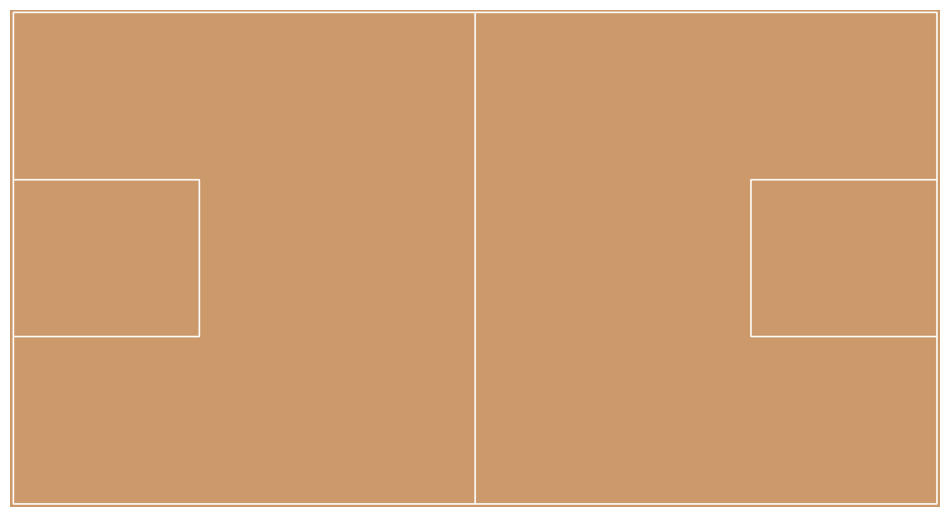

In [ ]:
annotated_frame = draw_court(CONFIG)
# 
sv.plot_image(annotated_frame)